In [ ]:
# Logistic Regression

Test Accuracy: 0.867
Test Precision: 0.559


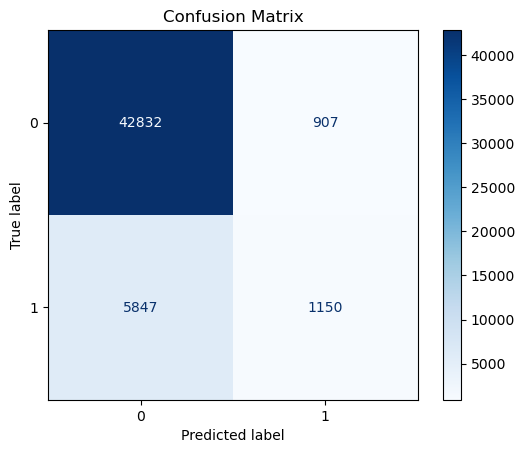

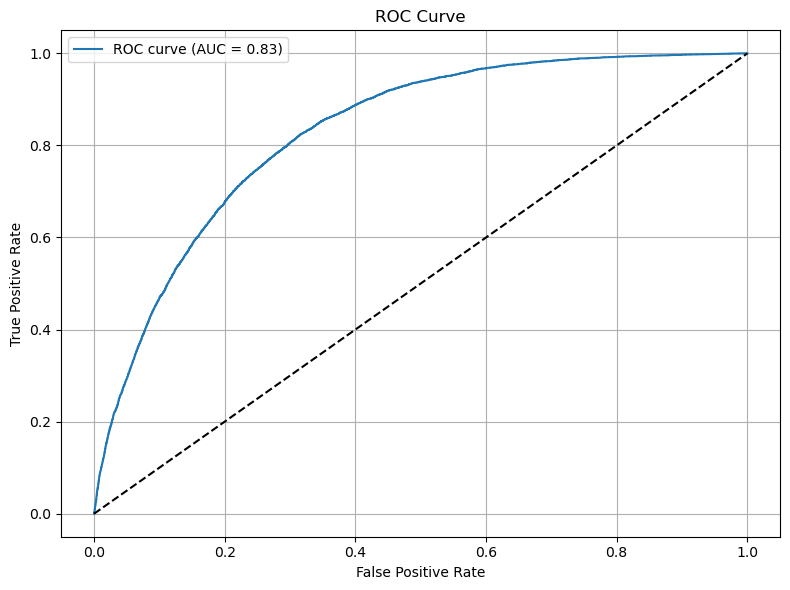

In [33]:
#Approach A
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("diabetes_dataset.csv", encoding='latin1', on_bad_lines='skip')

# Drop index column if present
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Separate features and target
X = df.drop(columns=['targets'])
y = df['targets']

# Categorical and numeric feature handling
categorical_cols = ['Education', 'Income', 'Age']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

# Logistic Regression with L2
logreg = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)

# Build pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', logreg)
])

# Train
pipe.fit(X_train, y_train)

# Predict
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.3f}")
print(f"Test Precision: {precision:.3f}")



# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

CV Accuracy: 0.863
Test Accuracy: 0.865
Test Precision: 0.543


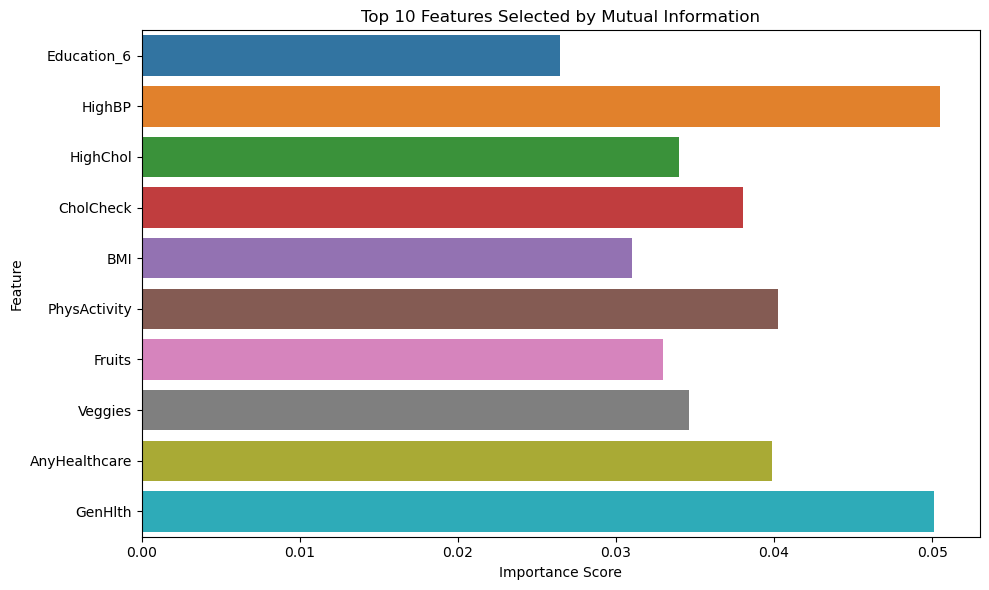

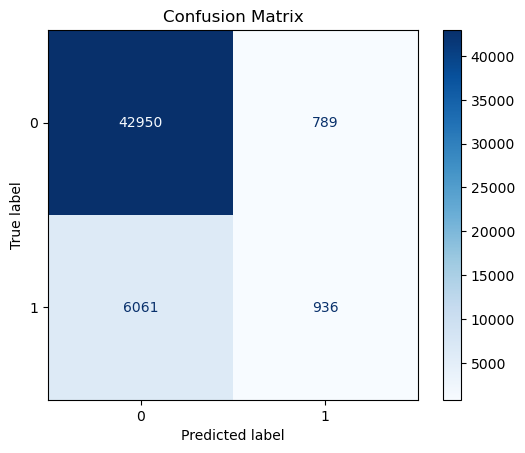

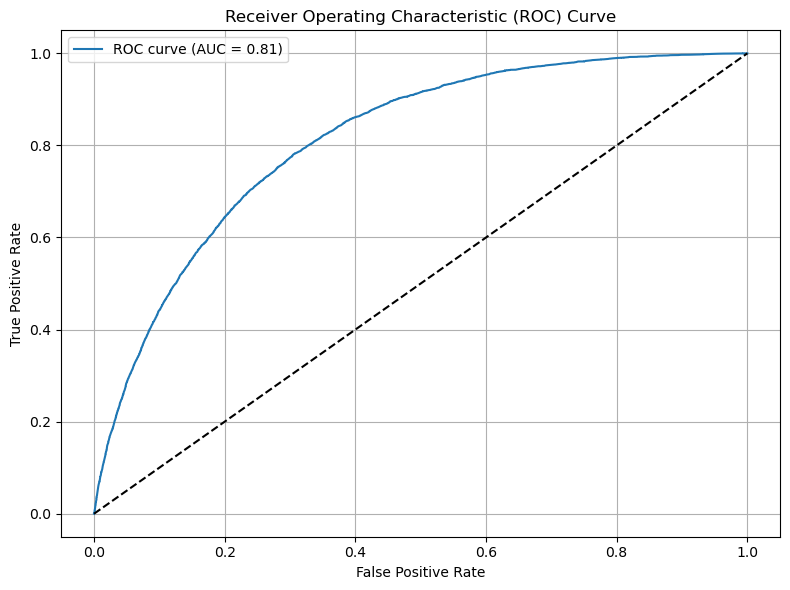

In [29]:
#Approach B
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from packaging import version
import numpy as np

df = pd.read_csv("diabetes_dataset.csv")

# Drop index column if present
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

X = df.drop(columns=['targets'])
y = df['targets']

categorical_cols = ['Education', 'Income', 'Age']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

encoder_kwargs = {'drop': 'first', 'handle_unknown': 'ignore'}
if version.parse(sklearn_version) >= version.parse("1.2"):
    encoder_kwargs['sparse_output'] = False
else:
    encoder_kwargs['sparse'] = False

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(**encoder_kwargs), categorical_cols)
], remainder='passthrough')

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectKBest(score_func=mutual_info_classif, k=10)),
    ('classifier', LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000))
])

# Cross-validation
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')

# Fit and evaluate
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"CV Accuracy: {cv_scores.mean():.3f}")
print(f"Test Accuracy: {accuracy:.3f}")
print(f"Test Precision: {precision:.3f}")

# Feature importances
ohe = preprocessor.named_transformers_['cat'].fit(X_train[categorical_cols])
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)
full_feature_names = list(ohe_feature_names) + numeric_cols
X_train_transformed = preprocessor.fit_transform(X_train)
selector = SelectKBest(score_func=mutual_info_classif, k=10).fit(X_train_transformed, y_train)
selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = np.array(full_feature_names)[selected_indices]

# Bar plot of top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x=selected_scores, y=selected_features)
plt.title("Top 10 Features Selected by Mutual Information")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
